# Flipkart TV Data Extraction, Analysis, and Prediction

This notebook covers:
1. **Web Scraping**: Extracting TV data from Flipkart (Name, Price, Ratings, Features, etc.).
2. **Data Cleaning**: Formatting and structuring the scraped data.
3. **Exploratory Data Analysis (EDA)**: Visualizing trends and insights.
4. **Machine Learning**: Predicting TV prices based on features.

In [9]:
import pandas as pd
import numpy as np
import requests
from bs4 import BeautifulSoup
import re
import matplotlib.pyplot as plt
import seaborn as sns

# ML Libraries
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score

# Configuration for plots

## 1. Web Scraping
We extract details like Product Name, Rating, Reviews, Price, Original Price, and Features.

In [11]:
def scrape_flipkart(page):
    url = f"https://www.flipkart.com/search?q=tv&page={page}"
    headers = {
        "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36"
    }
    try:
        response = requests.get(url, headers=headers)
        response.raise_for_status()
        soup = BeautifulSoup(response.content, "html.parser")

        def safe_extract(tag, class_name):
            return [x.get_text(" ", strip=True) for x in soup.find_all(tag, {'class': class_name})]

        names = safe_extract('div', 'KzDlHZ')
        ratings = safe_extract('div', 'XQDdHH')
        infos = safe_extract('div', '_6NESgJ')
        prices = safe_extract('div', 'Nx9bqj _4b5DiR')
        original_prices = safe_extract('div', 'yRaY8j') # Strikethrough price
        offers = safe_extract('div', 'UkUFwK')
        rating_counts = safe_extract('span', 'Wphh3N') 
        
        max_len = max(len(names), len(prices))
        
        # Helper to pad lists
        def pad(lst, length, fill=np.nan):
            return lst + [fill] * (length - len(lst))

        data = {
            "TV_Name": pad(names, max_len),
            "Rating": pad(ratings, max_len),
            "Info_Raw": pad(infos, max_len),
            "Price": pad(prices, max_len),
            "Original_Price": pad(original_prices, max_len),
            "Offers": pad(offers, max_len),
            "Rating_Count": pad(rating_counts, max_len)
        }
        
        return pd.DataFrame(data)
    
    except Exception as e:
        print(f"Error on page {page}: {e}")
        return pd.DataFrame()

# Example usage (Uncomment to run)
all_data = pd.DataFrame()
for page in range(1,53):
    print(f"Scraping page {page}...")
    df_page = scrape_flipkart(page)
    all_data = pd.concat([all_data, df_page], ignore_index=True)
# For now, we will load the existing dataset if available
try:
    df = pd.read_csv("Flipkart_TV_Splitted_Cleaned.csv")
    print("Loaded existing dataset.")
except FileNotFoundError:
    print("Dataset not found. Please run the scraping loop.")
    df = pd.DataFrame()

Scraping page 1...
Error on page 1: All arrays must be of the same length
Scraping page 2...
Error on page 2: All arrays must be of the same length
Scraping page 3...
Error on page 3: All arrays must be of the same length
Scraping page 4...
Error on page 4: All arrays must be of the same length
Scraping page 5...
Error on page 5: All arrays must be of the same length
Scraping page 6...
Scraping page 7...
Error on page 7: All arrays must be of the same length
Scraping page 8...
Error on page 8: All arrays must be of the same length
Scraping page 9...
Error on page 9: All arrays must be of the same length
Scraping page 10...
Error on page 10: All arrays must be of the same length
Scraping page 11...
Error on page 11: All arrays must be of the same length
Scraping page 12...
Error on page 12: All arrays must be of the same length
Scraping page 13...
Error on page 13: All arrays must be of the same length
Scraping page 14...
Error on page 14: All arrays must be of the same length
Scraping 

## 2. Data Cleaning & Feature Extraction
We process the raw text to extract meaningful features like Resolution, Screen Size, Brand, and Operating System.

In [ ]:
# If starting from raw scraped data, apply these cleaning steps:
if 'Info_Raw' in df.columns:
    # Extract Resolution
    df['Resolution'] = df['Info_Raw'].str.extract(r'^(.*?)\s*\|')
    
    # Extract Panel Type
    df['Panel_Type'] = df['Info_Raw'].str.extract(r'\|\s*(.*?)\s*Model ID')
    
    # Extract Launch Year
    df['Launch_Year'] = df['Info_Raw'].str.extract(r'Launch Year:\s*(\d{4})').astype(float)
    
    # Extract Sound Output
    df['Sound_Output'] = df['Info_Raw'].str.extract(r'Total Sound Output:\s*(\d+)\s*W').astype(float)

    # Extract Brand (First word of Name)
    df['Brand'] = df['TV_Name'].str.split().str[0]

    # Extract Size in Inches
    df['Size_inch'] = df['TV_Name'].str.extract(r'\((\d+)\s*inch').astype(float)

    # Clean Price
    if df['Price'].dtype == 'O':
        df['Price'] = df['Price'].astype(str).str.replace('₹', '').str.replace(',', '').astype(float)

    # Extract OS Type
    def get_os(x):
        x = str(x).lower()
        if "google tv" in x: return "Google TV"
        if "android" in x: return "Android TV"
        if "webos" in x: return "WebOS"
        if "tizen" in x: return "Tizen"
        if "fire tv" in x: return "Fire TV"
        if "linux" in x: return "Linux"
        return "Other"
    
    df['OS_Type'] = df['TV_Name'].apply(get_os)

# Drop duplicates and missing critical values
df.dropna(subset=['Price', 'TV_Name'], inplace=True)
df.drop_duplicates(inplace=True)

print(f"Data Shape after cleaning: {df.shape}")
df.head()

df.to_csv("cleaned_data.csv", index=False)


Data Shape after cleaning: (943, 16)


## 3. Exploratory Data Analysis (EDA)
Analyzing the data to understand distributions and relationships.

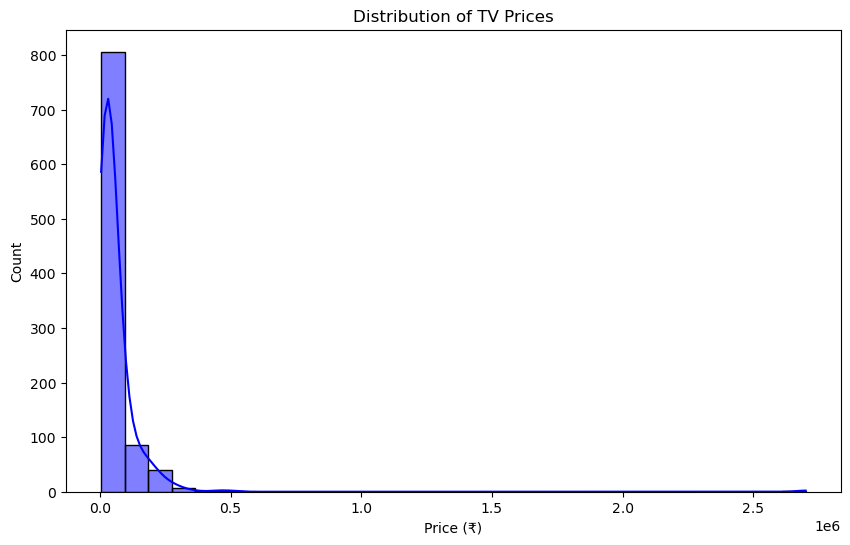

C:\Users\nkris\AppData\Local\Temp\ipykernel_4216\2613840335.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Brand', y='Price', data=df[df['Brand'].isin(top_brands)], estimator=np.mean, palette='viridis')


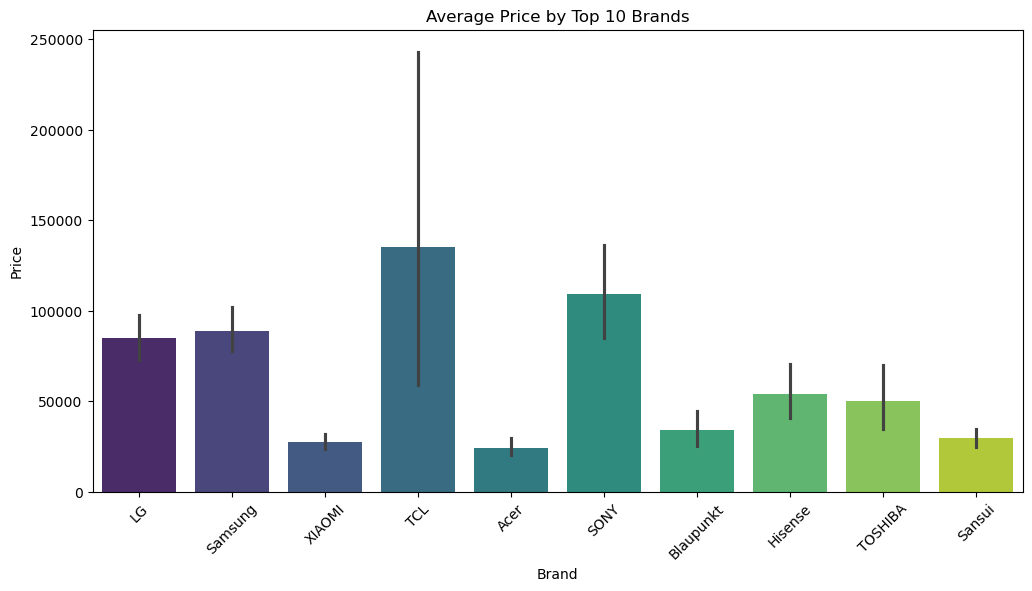

C:\Users\nkris\AppData\Local\Temp\ipykernel_4216\2613840335.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y='OS_Type', data=df, order=df['OS_Type'].value_counts().index, palette='magma')


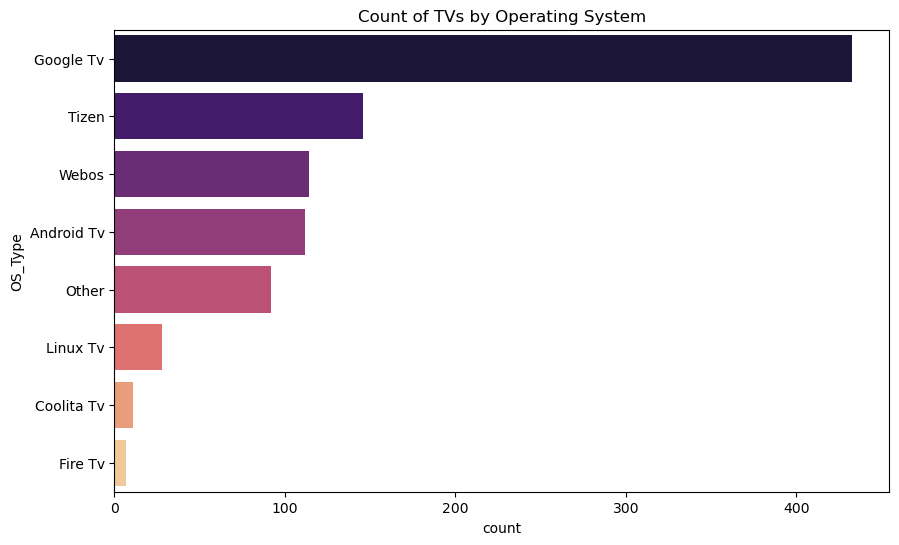

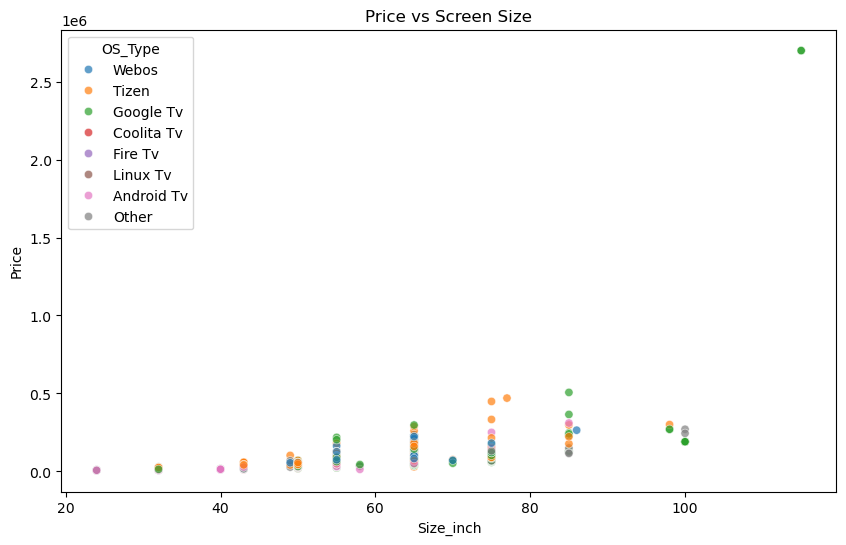

In [ ]:
# 1. Price Distribution
plt.figure(figsize=(10, 6))
sns.histplot(df['Price'], bins=30, kde=True, color='blue')
plt.title('Distribution of TV Prices')
plt.xlabel('Price (₹)')
plt.show()

# 2. Average Price by Brand (Top 10)
if 'Brand' not in df.columns:
    df['Brand'] = df['TV_Name'].str.split().str[0]

top_brands = df['Brand'].value_counts().nlargest(10).index
plt.figure(figsize=(12, 6))
sns.barplot(x='Brand', y='Price', data=df[df['Brand'].isin(top_brands)], estimator=np.mean, palette='viridis')
plt.title('Average Price by Top 10 Brands')
plt.xticks(rotation=45)
plt.show()

# 3. OS Type Count
plt.figure(figsize=(10, 6))
sns.countplot(y='OS_Type', data=df, order=df['OS_Type'].value_counts().index, palette='magma')
plt.title('Count of TVs by Operating System')
plt.show()

# 4. Price vs Screen Size
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Size_inch', y='Price', data=df, hue='OS_Type', alpha=0.7)
plt.title('Price vs Screen Size')
plt.show()

## 4. Machine Learning: Price Prediction
We will build a model to predict the price of a TV based on its specifications.

C:\Users\nkris\AppData\Local\Temp\ipykernel_4216\2000851888.py:9: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  ml_df['Rating'].fillna(ml_df['Rating'].mean(), inplace=True)
C:\Users\nkris\AppData\Local\Temp\ipykernel_4216\2000851888.py:10: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a cop

Model Performance:
Mean Absolute Error: ₹13390.99
R2 Score: 0.74


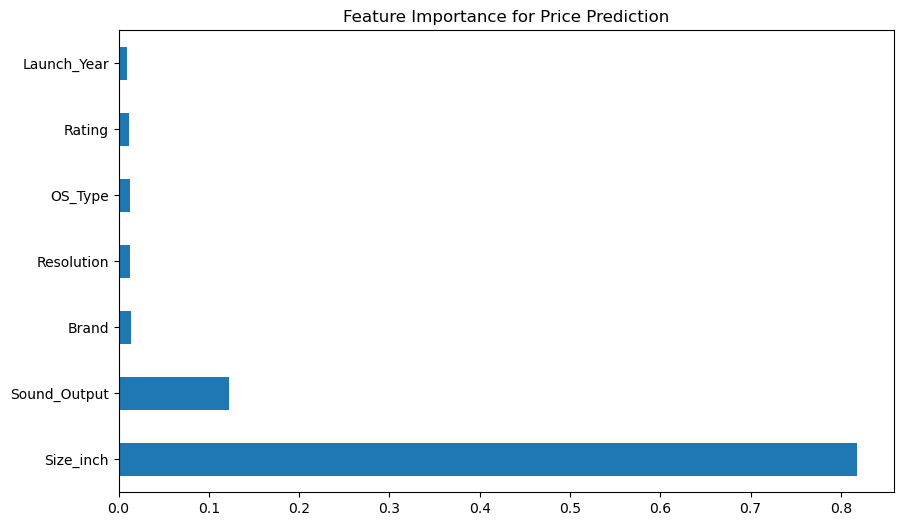

In [ ]:
# Select Features for Prediction
features = ['Brand', 'Resolution', 'Size_inch', 'Sound_Output', 'OS_Type', 'Launch_Year', 'Rating']
target = 'Price'

# Filter data to ensure we have these columns
ml_df = df[features + [target]].copy()

# Handle Missing Values
ml_df['Rating'].fillna(ml_df['Rating'].mean(), inplace=True)
ml_df['Launch_Year'].fillna(ml_df['Launch_Year'].mode()[0], inplace=True)
ml_df['Sound_Output'].fillna(ml_df['Sound_Output'].median(), inplace=True)
ml_df.dropna(inplace=True)

# Encode Categorical Variables
le = LabelEncoder()
categorical_cols = ['Brand', 'Resolution', 'OS_Type']
for col in categorical_cols:
    ml_df[col] = le.fit_transform(ml_df[col].astype(str))

# Split Data
X = ml_df[features]
y = ml_df[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Model (Random Forest)
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Predictions
y_pred = rf_model.predict(X_test)

# Evaluation
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Model Performance:")
print(f"Mean Absolute Error: ₹{mae:.2f}")
print(f"R2 Score: {r2:.2f}")

# Feature Importance
plt.figure(figsize=(10, 6))
feat_importances = pd.Series(rf_model.feature_importances_, index=X.columns)
feat_importances.nlargest(10).plot(kind='barh')
plt.title('Feature Importance for Price Prediction')
plt.show()